# Analytical Question

The objective was to analyze how different factors, including study habits, socioeconomic status, and sleep, influence student grades. We aimed to determine which features contribute most to predicting academic performance.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import psycopg2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'Ashok%403999' # this is the password established during installation
port = r'5432' # default port estabalished during install
schema = r'raw' # schema we just created

In [12]:
from sqlalchemy import create_engine

# create a connection to the database
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{db}')
db_conn = engine.connect()

In [13]:

table_name = r'Student_Performance'
Student_raw = pd.read_sql_table(table_name, db_conn, schema)
Student_raw.head()


,Socioeconomic Score,Study Hours,Sleep Hours,Attendance (%),Grades
0,0.95822,3.4,8.2,53.0,47.0
1,0.85566,3.2,5.9,55.0,35.0
2,0.68025,3.2,9.3,41.0,32.0
3,0.25936,3.2,8.2,47.0,34.0
4,0.60447,3.8,10.0,75.0,33.0


In [15]:
# Data Cleaning: Handling missing values
Student_raw.dropna(inplace=True)
Student_raw.isnull().sum()

Socioeconomic Score    0
Study Hours            0
Sleep Hours            0
Attendance (%)         0
Grades                 0
dtype: int64

# Feature Engineering

**Effective Study Time**

Effective Study Time = Study Hours × (Attendance % / 100)
This feature accounts for the actual study time adjusted by attendance, hypothesizing that higher attendance enhances the impact of study hours.


**Average Study Hours Per Week**

In [17]:
Student_raw['Avg_Study_Hours_Per_Week'] = Student_raw['Study Hours'] * 7

This may give a clearer picture of how committed the students are to learning for a week. You can include this feature if you have a column for number of weeks or semester.

 **Study-to-Sleep Ratio**

In [18]:
Student_raw['Study_to_Sleep_Ratio'] = Student_raw['Study Hours'] / (Student_raw['Sleep Hours'] + 1) 

The way study hours and sleep interact may be important. If the student studies more but sleeps less, his or her performance will suffer from the shorter sleep. This variable captures that interaction.

**Study_Attendance_Interaction**

In [20]:

Student_raw["Study_Attendance_Interaction"] = Student_raw["Study Hours"] * Student_raw["Attendance (%)"]
Student_raw["Sleep_Category"] = pd.cut(Student_raw["Sleep Hours"], bins=[0, 4, 7, 10], labels=[1, 2, 3])

The "Study_Attendance_Interaction" feature is the product of "Study Hours" and "Attendance (%)\\," and it denotes the interaction effect of study time and class attendance on student performance. The "Sleep_Category" feature divides the sleep hours of students into three ranges (1: 0-4 hours, 2: 4-7 hours, 3: 7-10 hours) to examine their sleep patterns' influence on academic performance.

In [22]:
# Convert categorical variables into numeric
Student_raw = pd.get_dummies(Student_raw, columns=["Sleep_Category"], drop_first=True)


In [24]:
# Select Features & Target (Make sure the encoded features are included)
features = ["Socioeconomic Score", "Study Hours", "Sleep Hours", "Attendance (%)",
            "Study_Attendance_Interaction"] + [col for col in Student_raw.columns if "Sleep_Category" in col]
target = "Grades"

In [26]:
# Splitting the dataset
X_train, X_temp, y_train, y_temp = train_test_split(Student_raw[features], Student_raw[target], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Display the shapes of the resulting datasets
X_train.shape, X_val.shape, X_test.shape

((971, 7), (208, 7), (209, 7))

In [30]:
# Convert column names to string type
X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Strip any unwanted leading/trailing spaces from column names (if necessary)
X_train.columns = X_train.columns.str.strip()
X_val.columns = X_val.columns.str.strip()
X_test.columns = X_test.columns.str.strip()

In [31]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [42]:
# Saving validatation dataset into csv files
X_val.to_csv('X Validation.csv', index=False)
y_val.to_csv('y Validation.csv', index=False)

In [41]:
# Train Model (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

Validation R² Score: 0.9794729755299544
Validation RMSE: 1.241211024641784
Validation MAE: 0.8720192307692307


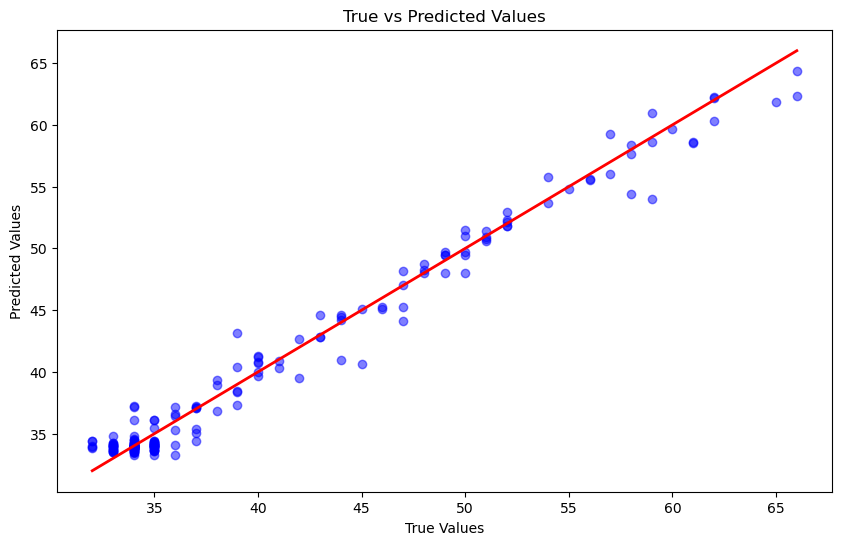

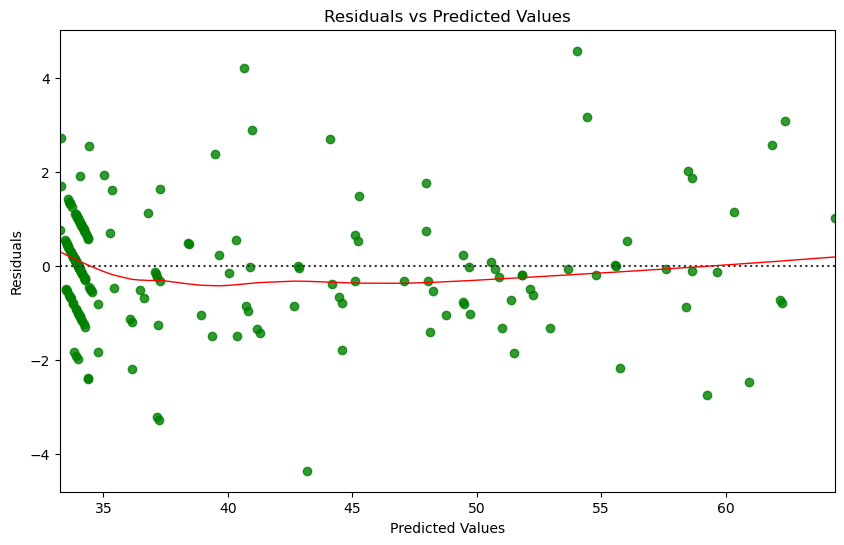

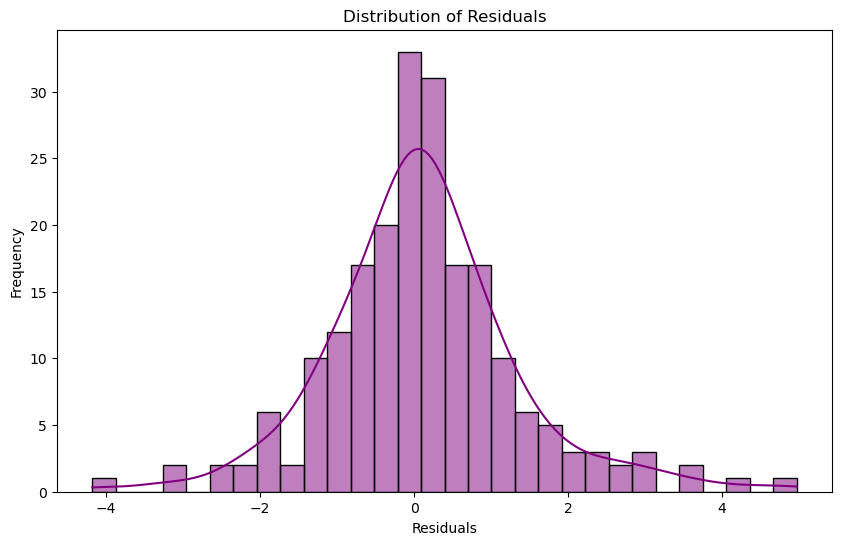

In [36]:

import matplotlib.pyplot as plt
import seaborn as sns
# Model Evaluation
y_pred_val = model.predict(X_val_scaled)
print("Validation R² Score:", r2_score(y_val, y_pred_val))
rmse = mean_squared_error(y_val, y_pred_val) ** 0.5
print("Validation RMSE:", rmse)

print("Validation MAE:", mean_absolute_error(y_val, y_pred_val))

# 1. Plotting True vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val, color='blue', alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', lw=2)  # 45-degree line
plt.title('True vs Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# 2. Plotting Residuals
residuals = y_val - y_pred_val
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred_val, y=residuals, lowess=True, color='green', line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# 3. Plotting a Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

### Model Evaluation Summary

**Validation R² Score: 0.9795**
- This very high R² score indicates that the model explains almost **97.95%** of the variance in the validation data. This suggests a good fit and very good predictive performance on unseen data.

**Validation RMSE: 1.2412**
- The **Root Mean Squared Error (RMSE)** of **1.2412** is very low, considering the context of the data and the size of the target variable. It indicates that, on average, the model predictions are about **1.24 units** away from true values.

**Validation MAE: 0.8720**
- The **Mean Absolute Error (MAE)** of **0.8720** is even lower than RMSE. MAE is the average absolute difference between predicted values and actual values. This shows that the model predictions are close to the actual values with fewer high errors.

---

### Overall Model Performance

- **High Validation R² Score**: The very high R² score (0.9795) suggests that the model is explaining almost 98% of the variance in the validation data. This indicates a good fit and solid predictive performance on unseen data.

- **Low Validation RMSE**: The low RMSE (1.2412) shows that the model is making accurate predictions, with an average error of only 1.24 units.

- **Low Validation MAE**: The low MAE (0.8720) further confirms that the model predictions are close to the actual values, with fewer large errors.

---

### Conclusion

The combination of a high R² score, low RMSE, and low MAE suggests that the model is performing very well on the validation set. The model is able to catch the underlying patterns in the data and make accurate predictions with minimal error.


In [37]:
# Save the model
joblib.dump(model, "student_grade_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']